In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams["font.family"] = "Noto sans"

pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 2)


# Matches

Text(0, 0.5, 'Anzahl an Spielen')

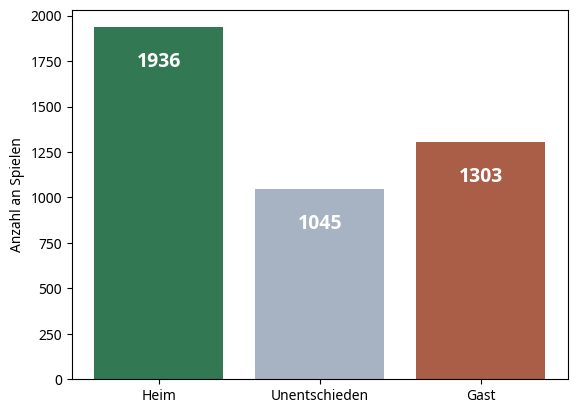

In [33]:
import colors

df_matches = pd.read_csv("data/matches.csv", index_col="id")
diffs = (df_matches["host_goals"] - df_matches["guest_goals"]).values
host_wins = np.count_nonzero(diffs > 0)
guest_wins = np.count_nonzero(diffs < 0)
draws = np.count_nonzero(diffs == 0)
fig, ax = plt.subplots()
rects = ax.bar(["Heim", "Unentschieden", "Gast"], [host_wins, draws, guest_wins], color=[colors.MATCH_RESULT["host_wins"], colors.MATCH_RESULT["draw"], colors.MATCH_RESULT["guest_wins"]])
ax.bar_label(rects, [host_wins, draws, guest_wins], padding=-32, color="white", weight="bold", size=14)
ax.set_ylabel("Anzahl an Spielen")

Text(0, 0.5, 'Count')

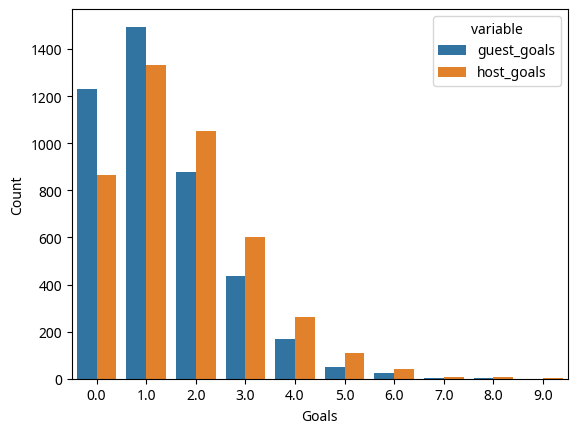

In [3]:
goals_long = df_matches[["host_goals", "guest_goals"]].melt().value_counts().reset_index()
ax = sns.barplot(goals_long, x="value", y="count", hue="variable")
ax.set_xlabel("Goals")
ax.set_ylabel("Count")

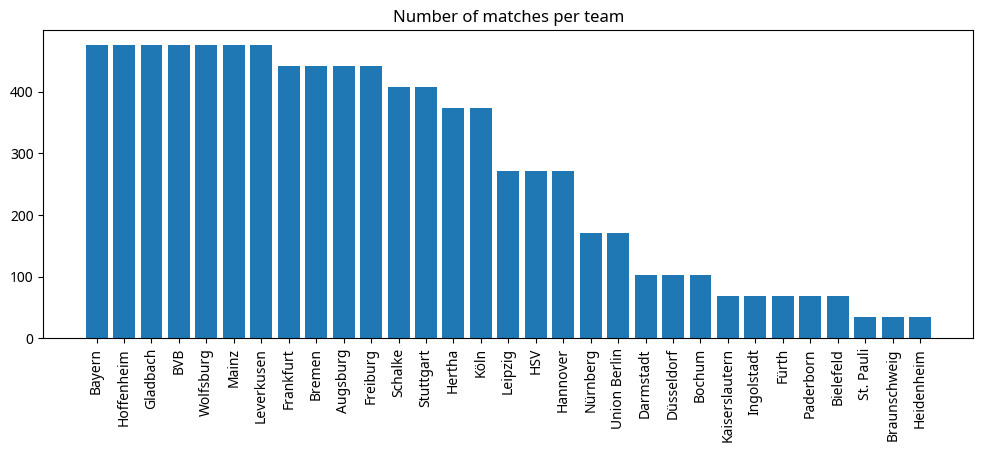

In [4]:
matches_per_team = {}
for name, n_matches in df_matches["host_name"].value_counts().to_dict().items():
    matches_per_team[name] = n_matches

for name, n_matches in df_matches["guest_name"].value_counts().to_dict().items():
    if name not in matches_per_team:
        matches_per_team[name] = 0
    matches_per_team[name] += n_matches

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Number of matches per team")
ax.bar(matches_per_team.keys(), matches_per_team.values())
ax.set_xticks(range(len(matches_per_team.keys())), matches_per_team.keys(), rotation=90, ha='center')
!

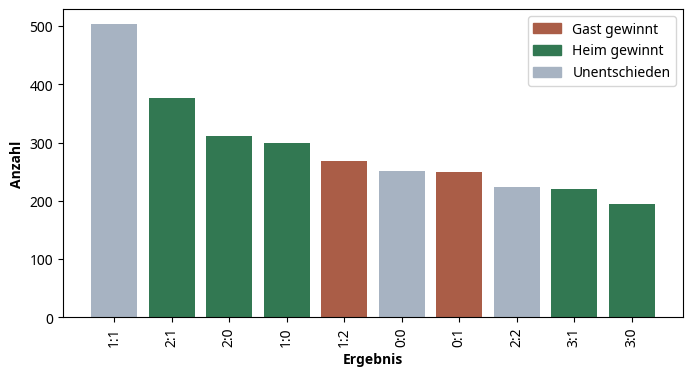

In [35]:
import colors

goals_encoded = [f"{int(r[0])}:{int(r[1])}" for r in df_matches[["host_goals", "guest_goals"]].values]
results, counts = np.unique(goals_encoded, return_counts=True)
sort = np.argsort(-counts)
counts = counts[sort]
results = results[sort]

top_k = 10
counts = counts[:top_k]
results = results[:top_k]

tendency = [1] * len(results)
for i, res in enumerate(results):
    goals = res.split(":")
    if goals[0] > goals[1]:
        tendency[i] = 0
    elif goals[0] < goals[1]:
        tendency[i] = 2

y_test_colors = [[colors.MATCH_RESULT["host_wins"], colors.MATCH_RESULT["draw"], colors.MATCH_RESULT["guest_wins"]][r] for r in tendency]
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(len(results)), counts, color=y_test_colors)
ax.set_xlabel("Ergebnis", weight="bold", fontname="Noto sans")
ax.set_ylabel(f"Anzahl", weight="bold")
ax.set_xticks(range(len(results)), results, rotation=90)

red_patch = mpatches.Patch(color=colors.MATCH_RESULT["guest_wins"], label='Gast gewinnt')
green_patch = mpatches.Patch(color=colors.MATCH_RESULT["host_wins"], label='Heim gewinnt')
gray_patch = mpatches.Patch(color=colors.MATCH_RESULT["draw"], label='Unentschieden')
ax.legend(handles=[red_patch, green_patch, gray_patch])

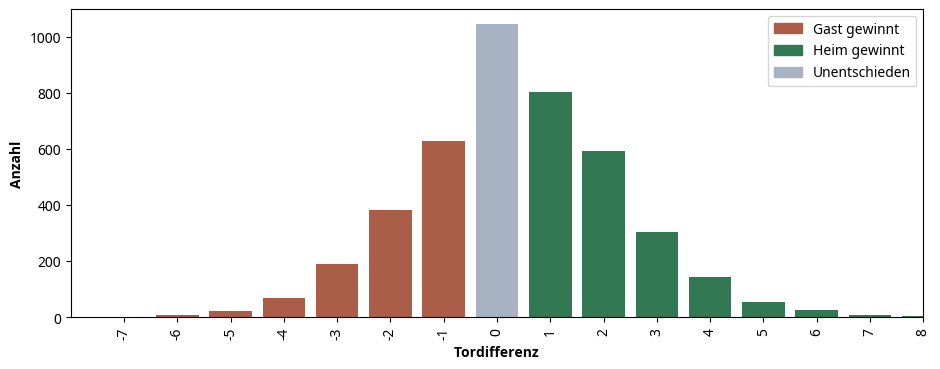

In [20]:
diff_counts = (df_matches["host_goals"] - df_matches["guest_goals"]).value_counts()
diff_colors = []
for diff in diff_counts.index:
    if diff == 0:
        diff_colors.append(colors.MATCH_RESULT["draw"])
    elif diff > 0:
        diff_colors.append(colors.MATCH_RESULT["host_wins"])
    elif diff < 0:
        diff_colors.append(colors.MATCH_RESULT["guest_wins"])


plt.figure(figsize=(11, 4))
plt.bar(diff_counts.index, diff_counts.values, color=diff_colors)
plt.xticks(rotation=90, ticks=diff_counts.index)
plt.ylabel("Anzahl", weight="bold")
plt.xlabel("Tordifferenz", weight="bold")
plt.xlim(-8, 8)
red_patch = mpatches.Patch(color=colors.MATCH_RESULT["guest_wins"], label='Gast gewinnt')
green_patch = mpatches.Patch(color=colors.MATCH_RESULT["host_wins"], label='Heim gewinnt')
gray_patch = mpatches.Patch(color=colors.MATCH_RESULT["draw"], label='Unentschieden')
plt.legend(handles=[red_patch, green_patch, gray_patch])
!

# Teams

In [7]:
df_team_names = df_matches[["host_id", "host_name"]].drop_duplicates().rename(columns={"host_id": "team_id", "host_name": "name"}).reset_index(drop=True)
df_team_names.tail()

,team_id,name
27,1635,Leipzig
28,80,Union Berlin
29,83,Bielefeld
30,129,Bochum
31,199,Heidenheim


In [8]:
df_team_stats = pd.merge(left=df_teams.groupby(["team"]).mean(), left_index=True, right=df_team_names, right_on="team_id")[["name", "points", "wins", "draws", "defeats", "goals", "opponent_goals"]]
df_team_stats = df_team_stats.sort_values(by="points", ascending=False)
df_team_stats.head()

NameError: name 'df_teams' is not defined

In [ ]:
corr = df_teams[["points", "wins", "draws", "defeats", "goals", "opponent_goals"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, cmap='BrBG')

# Historic Relationships

In [ ]:
df_teams_last_season = df_teams.copy()
df_teams_last_season["year"] += 1

df_teams_with_last = pd.merge(left=df_teams, right=df_teams_last_season, on=["team", "year"], suffixes=("", "_last"), how="left")
print(len(df_teams_with_last))
df_teams_with_last = df_teams_with_last.dropna()
print(len(df_teams_with_last))
corr = df_teams_with_last[["points", "points_last", "wins", "wins_last", "draws", "draws_last", "defeats", "defeats_last", "goals", "goals_last"]].corr()
corr = corr.drop(columns=["points", "wins", "goals", "draws", "defeats"])
corr = corr.drop(["points_last", "wins_last", "goals_last", "draws_last", "defeats_last"])

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='BrBG')